# Post-COVID Evaluation

In [1]:
import sys
sys.path.append('../')
from src.scoring_functions import *
from src.load_data import *

In [2]:
def add_truth(df, source='icosari', disease='sari', target=False):
    if target:
        df_truth = pd.read_csv(f'https://raw.githubusercontent.com/KITmetricslab/RESPINOW-Hub/main/data/{source}/{disease}/target-{source}-{disease}.csv')
    else:
        df_truth = pd.read_csv(f'https://raw.githubusercontent.com/KITmetricslab/RESPINOW-Hub/main/data/{source}/{disease}/latest_data-{source}-{disease}.csv')
        
    df_truth = df_truth.rename(columns={'value': 'truth'})

    df = df.merge(df_truth, how='left', 
                   left_on=['location', 'age_group', 'target_end_date'], 
                   right_on=['location', 'age_group', 'date'])
    return df

In [3]:
# files = glob.glob(f'../data/post-covid/submissions/**/*.csv', recursive=True)

In [4]:
def load_predictions(period='post-covid', start='2023-12-14', end='2024-09-19', include_median=True, include_truth=True, target=True):
    files = glob.glob(f'../data/{period}/submissions/**/*.csv', recursive=True)
    files = [f for f in files if '/old/' not in f]
    
    dfs = []
    for file in files:
        df_temp = pd.read_csv(file)
        df_temp['model'] = file.split('/')[-1].split('-', 5)[-1][:-4] 
        dfs.append(df_temp)
    df = pd.concat(dfs)
    
    if include_median:
        df = add_median(df)
    if include_truth:
        df = add_truth(df, source='icosari', disease='sari', target=target)

    return df[df.forecast_date.between(start, end)]

In [37]:
df = load_predictions('post-covid')

In [38]:
df.model.unique()

array(['lightgbm2', 'lightgbm', 'tsmixer', 'KIT-MeanEnsemble', 'KIT-hhh4'],
      dtype=object)

In [39]:
# df.value = df.value.round()

In [40]:
# df = df[df.forecast_date != '2023-12-28']

In [9]:
model_names = {
    'KIT-MeanEnsemble' : 'Ensemble',
    'lightgbm' : 'LightGBM',
    'tsmixer' : 'TSMixer',
    'KIT-hhh4' : 'hhh4'
}

In [41]:
model_colors = {
    "LightGBM": "#B30000",
    "TSMixer": "#E69F00",
    "KIT-frozen_baseline": "#999999",
    "KIT": "#56B4E9",
    "LMU": "#F0E442",
    "Ensemble": "#009E73",
    "MedianEnsemble": "#60D1B3",
    "RIVM": "#80471C",
    "hhh4": "#3C4AAD",
    "SU": "#CC79A7",
    "SZ": "#000000"
}

In [42]:
df.model = df.model.replace(model_names)

In [43]:
df = df[df.model != 'lightgbm2']

#### National level

In [12]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Ensemble,377.213995,172.441267,650.415435,1200.070698,0.317073,0.926829
1,LightGBM,357.971271,56.782013,858.307288,1273.060572,0.390244,0.908537
2,TSMixer,420.129774,289.905952,595.242153,1305.277879,0.353659,0.878049
3,hhh4,353.540941,434.439024,789.575784,1577.555749,0.250000,0.725610


#### Age groups

In [13]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Ensemble,84.707510,46.903707,103.294556,234.905773,0.417683,0.909553
1,LightGBM,61.954686,36.393227,161.509453,259.857366,0.272358,0.757114
2,hhh4,103.873403,85.830285,94.195703,283.899390,0.486789,0.908537
3,TSMixer,88.294441,62.071067,140.293788,290.659297,0.340447,0.742886


In [44]:
def compute_scores(df):
    # Apply the scoring function row-wise and round the result to 5 digits
    df_scores = (
        df.assign(score=lambda x: x.apply(lambda row: round(score(row['value'], row['truth'], row['type'], row['quantile']), 5), axis=1))
          .drop(columns=['value', 'truth'])
    )
    return df_scores

In [45]:
scores = compute_scores(df)

In [46]:
# scores[(scores.age_group == '00+') & (scores.type == 'quantile')].groupby('model')['score'].mean()

# Plots

In [47]:
from plotnine import ggplot, aes, geom_bar, geom_label, scale_alpha_manual, labs, coord_flip, theme_bw, theme, geom_line, scale_alpha_discrete, guide_legend

In [48]:
from plotnine import *

In [139]:
df_national = evaluate_models(df, 'national')

In [140]:
df_age = evaluate_models(df, 'age')

In [141]:
scores_national = pd.melt(df_national, id_vars=['model'], value_vars=['underprediction', 'spread', 'overprediction'], 
                 var_name='penalty', value_name='value')

In [142]:
scores_age = pd.melt(df_age, id_vars=['model'], value_vars=['underprediction', 'spread', 'overprediction'], 
                 var_name='penalty', value_name='value')

In [149]:
desired_order = ['Ensemble', 'LightGBM', 'TSMixer', 'hhh4']
desired_order.reverse()

# Convert 'model' column to a categorical type with the specified order in both DataFrames
df_national['model'] = pd.Categorical(df_national['model'], categories=desired_order, ordered=True)
scores_national['model'] = pd.Categorical(scores_national['model'], categories=desired_order, ordered=True)

df_age['model'] = pd.Categorical(df_age['model'], categories=desired_order, ordered=True)
scores_age['model'] = pd.Categorical(scores_age['model'], categories=desired_order, ordered=True)

In [144]:
#df_national['model'] = pd.Categorical(df_national['model'], categories=['Ensemble', 'LightGBM', 'TSMixer', 'hhh4'].reverse(), ordered=True)

In [145]:
#scores_national = scores_national.sort_values('model', ascending=False, ignore_index=True)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


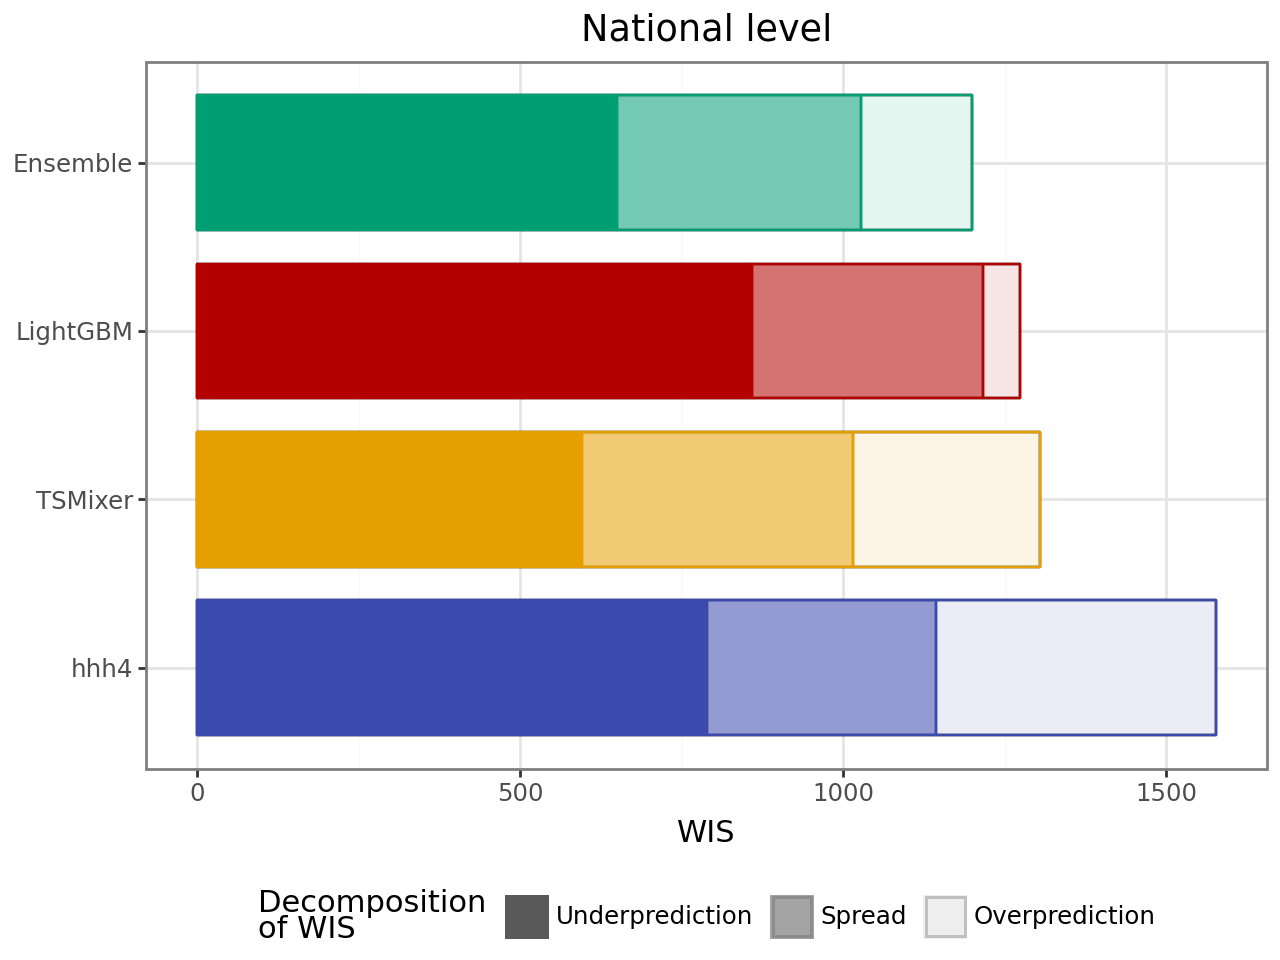

In [157]:
p = (ggplot()
    + geom_bar(df_national, aes(x='model', y='wis'), fill='white', color='black', stat='identity', width=0.8)
    + geom_bar(scores_national, aes(x='model', y='value', fill='model', alpha='penalty', color='model'), stat='identity', width=0.8,
               show_legend={'color': False,
                            'fill': False,
                            'alpha': True})
    + scale_color_manual(values=model_colors)
    + scale_fill_manual(values=model_colors)
    + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=True))
    + labs(x="", y="WIS", color="Model", alpha="Decomposition\nof WIS", title="National level")
    + coord_flip()
    + theme_bw()
    + theme(legend_position='bottom',
            legend_title=element_text(ha='center'))
   )
p

In [158]:
p.save("../figures/wis_national.pdf", width = 150, height = 90, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 150.0 x 90.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_national.pdf


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


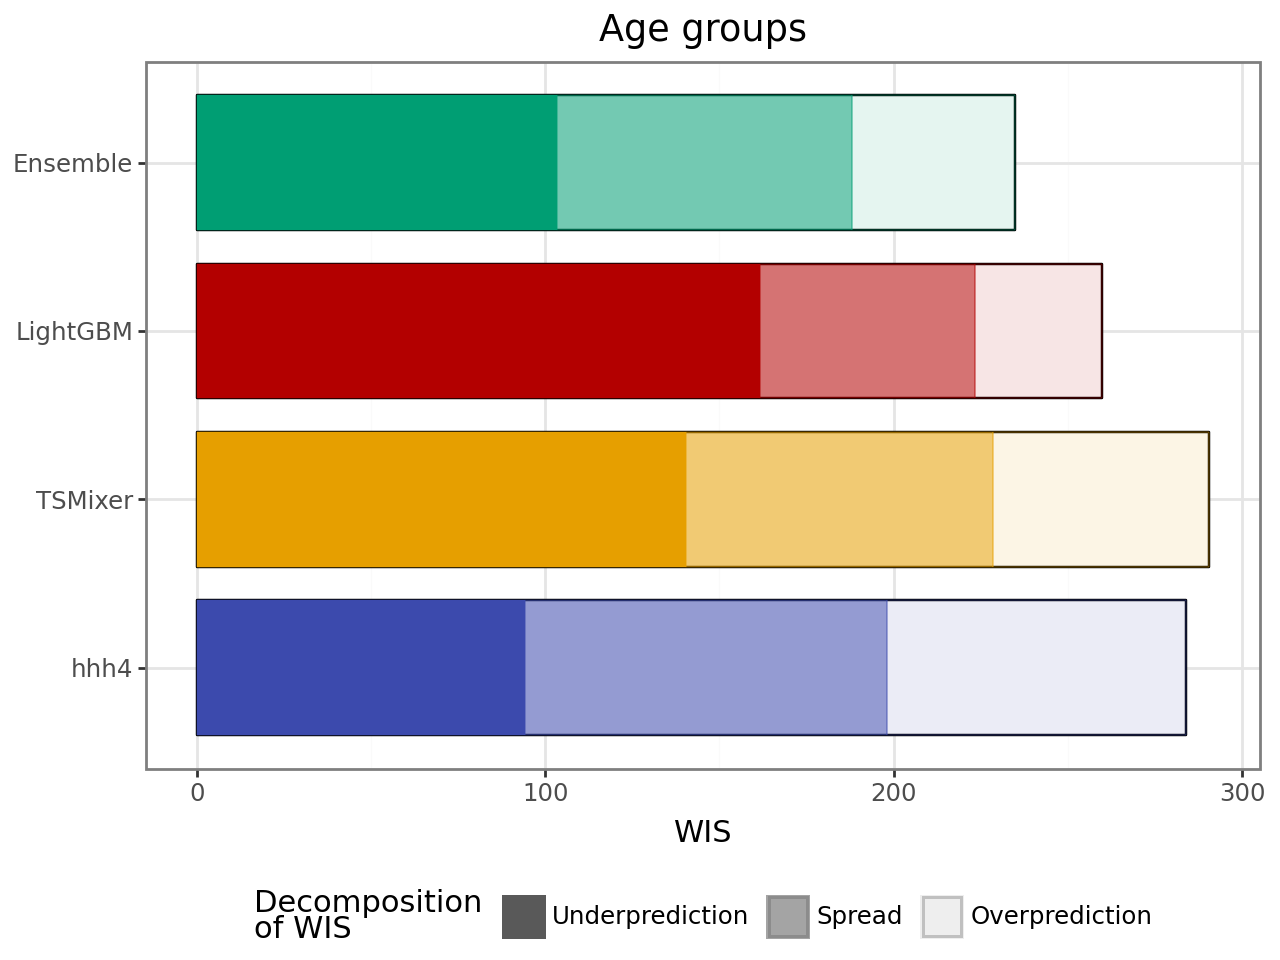

In [159]:
p = (ggplot()
    + geom_bar(df_age, aes(x='model', y='wis'), fill='white', color='black', stat='identity', width=0.8)
    + geom_bar(scores_age, aes(x='model', y='value', fill='model', alpha='penalty', color='model'), size=0.1, stat='identity', width=0.8, 
               show_legend={'color': False,
                            'fill': False,
                            'alpha': True})
    + scale_color_manual(values=model_colors)
    + scale_fill_manual(values=model_colors)
    + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=True))
    + labs(x="", y="WIS", color="Model", alpha="Decomposition\nof WIS", title="Age groups")
    + coord_flip()
    + theme_bw()
    + theme(legend_position='bottom')
   )
p

In [161]:
p.save("../figures/wis_age_mean.pdf", width = 150, height = 90, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 150.0 x 90.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age_mean.pdf


In [33]:
from plotnine import *
import matplotlib.pyplot as plt

In [34]:
def filter_scores(df, type="quantile", level="national", by_horizon=False, average=True):
    # Filter by type
    df = df[df['type'] == type]

    # Filter by level
    if level == "national":
        df = df[(df['location'] == "DE") & (df['age_group'] == "00+")]
    elif level == "states":
        df = df[(df['location'] != "DE")]
    elif level == "age":
        df = df[(df['location'] == "DE") & (df['age_group'] != "00+")]
                
    if by_horizon:
        if average:
            df = df.groupby(['model', 'horizon'], as_index=False).agg(score=('score', 'mean'))
            df = df.sort_values(by=['model', 'horizon'])
    else:
        if average:
            df = df.groupby(['model'], as_index=False).agg(score=('score', 'mean'))
        else:
            df = df.groupby(['model', 'location', 'age_group'], as_index=False).agg(score=('score', 'mean'))

    return df

In [35]:
def plot_scores_by_horizon(scores, level='national'):
    
    scores = filter_scores(scores, type='quantile', level=level, by_horizon=True, average=True)
    
    ylabel = "Mean WIS"

    plot = (
        ggplot(scores, aes(x='horizon', y='score', color='model')) +
        geom_line(size=1) +
        labs(
            x="Horizon (days)",
            y=ylabel,
            color="Model"
        ) +
        #scale_x_continuous(breaks=[i * -5 for i in range(6)], minor_breaks=range(-28, 1)) +
        scale_y_continuous(limits=(0, None)) +
        theme_bw() +
        theme(legend_position="right")
    )

    return plot

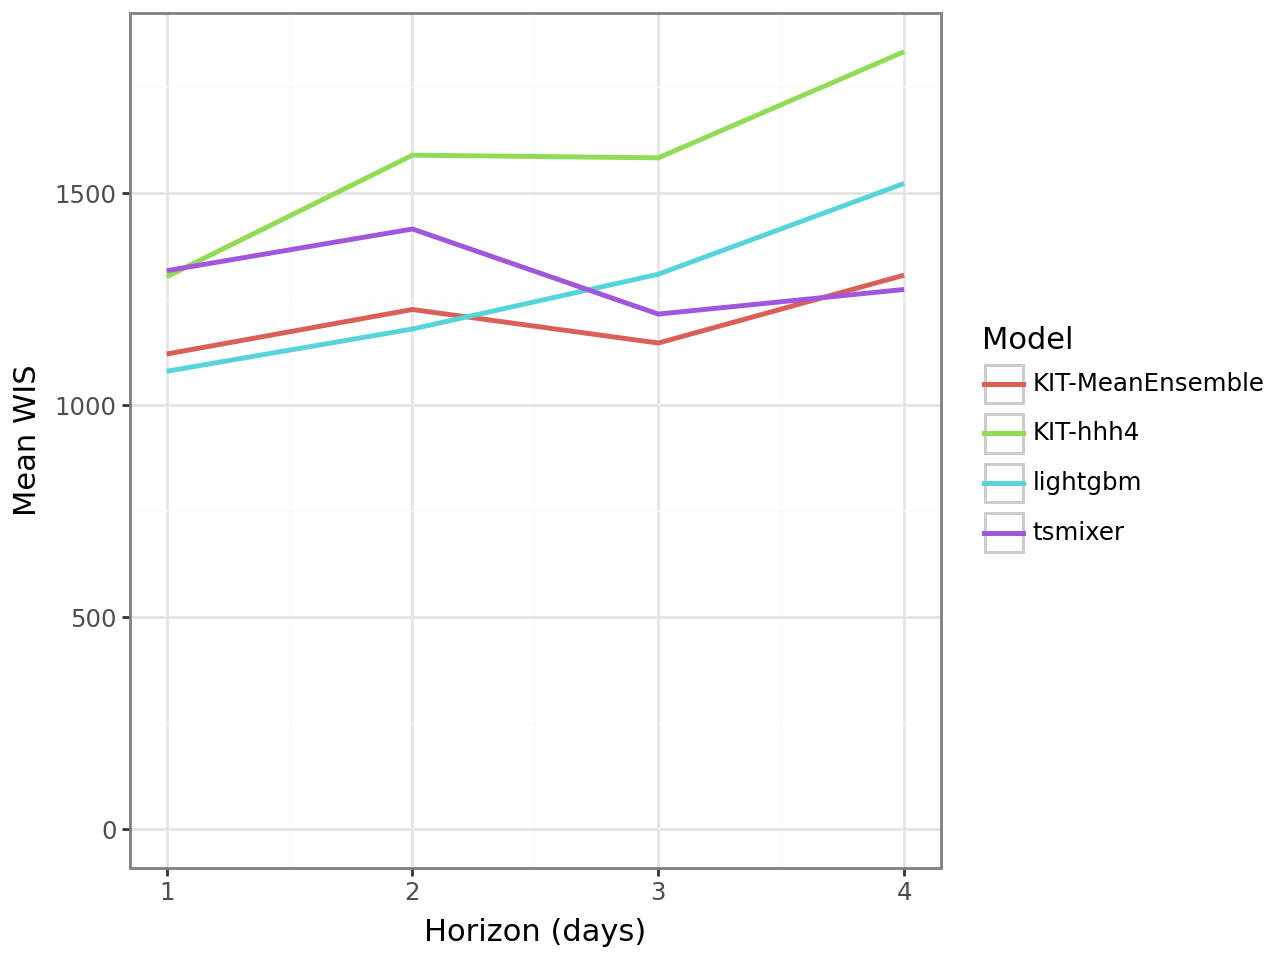

In [36]:
plot_scores_by_horizon(scores)

In [46]:
def plot_scores_by_horizon_and_model(scores, level='national'):
    scores = filter_scores(scores, type='quantile', level=level, by_horizon=True, average=True)
    
    # Sort the DataFrame by 'horizon' and 'score'
    scores = scores.sort_values(by=['horizon', 'score'])

    # Create a new column for sorted models within each horizon
    scores['model'] = pd.Categorical(scores['model'], 
                                      categories=scores.groupby('horizon')['model'].apply(lambda x: x.tolist()).explode().unique(),
                                      ordered=True)    
    plot = (
        ggplot(scores, aes(x='model', y='score', fill='model')) +
        geom_bar(stat='identity', position='dodge') +
        labs(
            x="",
            y="WIS",
            title="National level" if (level=='national') else "Age groups"
        ) +
        facet_wrap('~horizon', nrow=1, labeller=lambda x: 'Horizon: ' + str(x)) +  # Create a facet for each horizon
        theme_bw() +
        theme(
            axis_text_x=element_text(rotation=45, ha="right"),
            legend_position='none'
        ) 
    )
    return plot

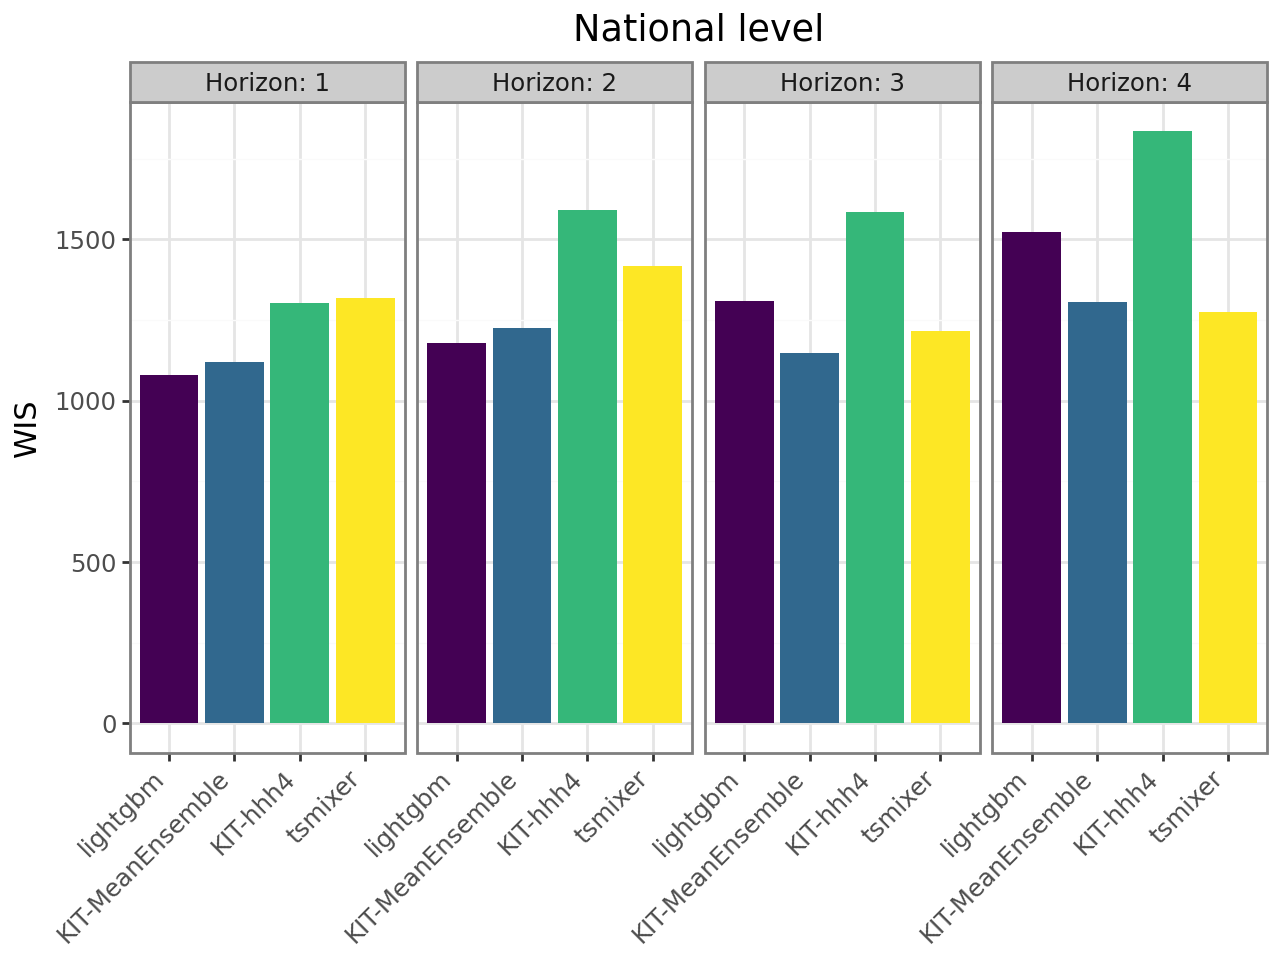

In [49]:
p = plot_scores_by_horizon_and_model(scores)
p

In [50]:
p.save("../figures/wis_national_horizon.pdf", width = 150, height = 90, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 150.0 x 90.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_national_horizon.pdf


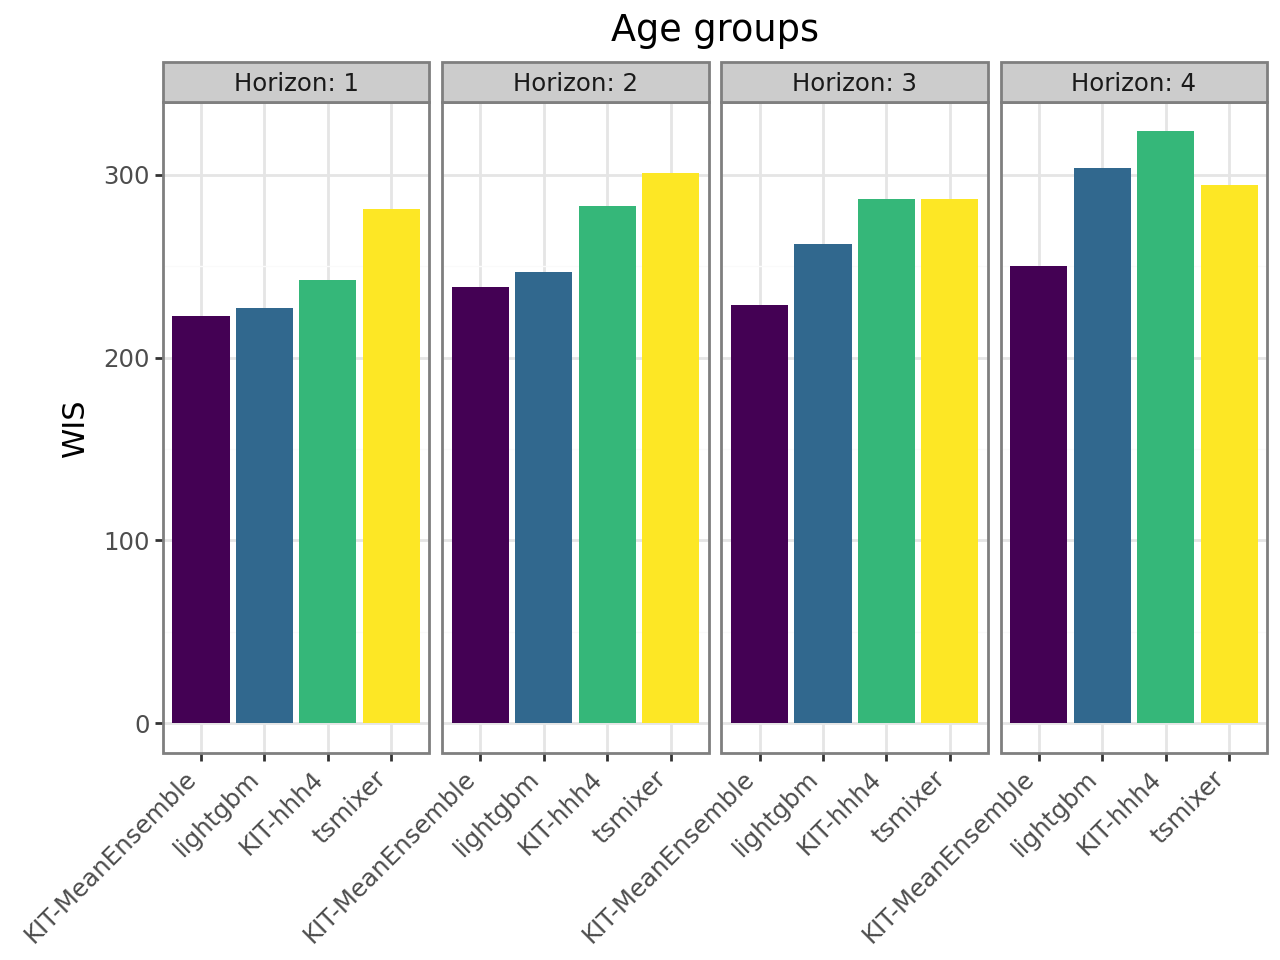

In [52]:
p = plot_scores_by_horizon_and_model(scores, level='age')
p

In [53]:
p.save("../figures/wis_age_horizon.pdf", width = 150, height = 90, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 150.0 x 90.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age_horizon.pdf


In [54]:
scores_age = filter_scores(scores, type='quantile', level='age', by_horizon=False, average=False)

In [57]:
def plot_scores_by_age_group(df):
    df['model'] = pd.Categorical(df['model'], 
                                  categories=scores.groupby('horizon')['model'].apply(lambda x: x.tolist()).explode().unique(),
                                  ordered=True)   
    plot = (
        ggplot(df, aes(x='model', y='score', fill='model')) +
        geom_bar(stat='identity', position='dodge') +
        labs(
            x="",
            y="WIS",
            title="WIS by age group"
        ) +
        facet_wrap('~age_group') +
        theme_bw() +
        theme(
            axis_text_x=element_text(rotation=45, ha="right"),
            legend_position='none'
        )
    )
    return plot

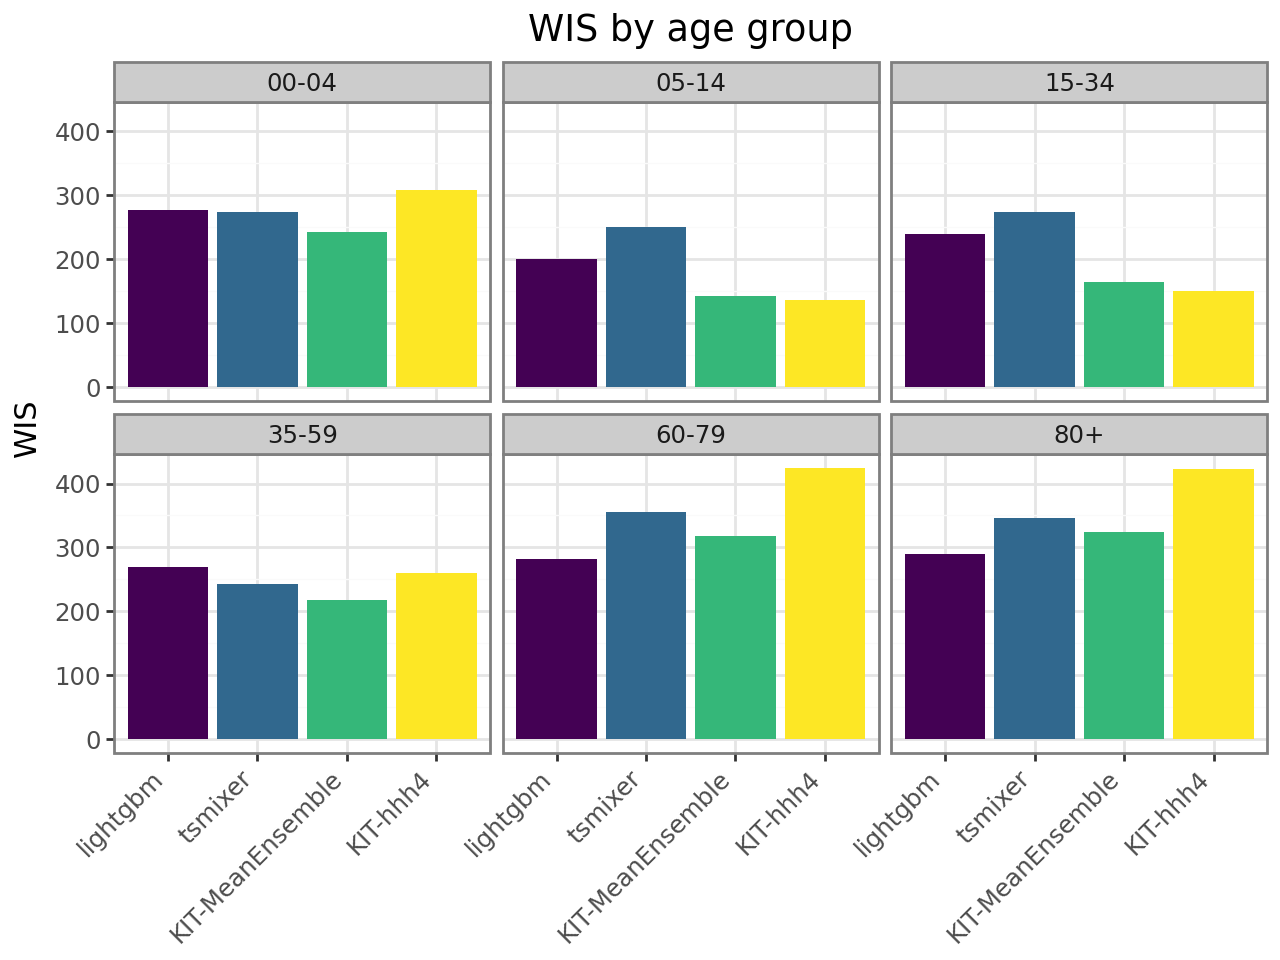

In [60]:
p = plot_scores_by_age_group(scores_age)
p

In [63]:
p.save("../figures/wis_age.pdf", width = 150, height = 110, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 150.0 x 110.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age.pdf
